In [ ]:
!python3 -m pip install bokeh pandas matplotlib

In [1]:
path = '~/.ros/tracing/canopen-controller-test5'

In [ ]:
# Make notebook full-width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import sys
import datetime as dt
from typing import List, Optional
from typing import Tuple
from typing import Union

import numpy as np
import pandas as pd

dir = '.' # os.path.dirname(os.path.realpath(__file__))
sys.path.insert(0, os.path.join(dir, '../../tracetools_analysis/tracetools_analysis'))
sys.path.insert(0, os.path.join(dir, '../../ros2_tracing/tracetools_read'))
from tracetools_analysis.loading import load_file
from tracetools_analysis.processor.ros2 import Ros2Handler
from tracetools_analysis.utils.ros2 import Ros2DataModelUtil

In [3]:
events = load_file(path)
handler = Ros2Handler.process(events)

found converted file: /home/admin/.ros/tracing/canopen-controller-test5/converted
 [100%] [Ros2Handler]


In [4]:
data_util = Ros2DataModelUtil(handler.data)

callback_symbols = data_util.get_callback_symbols()

In [5]:
data_util.data.print_data()

====================ROS 2 DATA MODEL===================
ROS2 CANopen tracing tpdo data:
                 timestamp          name  node_id    data
0      1683723156343901348  prbt_joint_5        7       0
1      1683723156345194449  prbt_joint_6        8       0
2      1683723156351957952  prbt_joint_2        4       0
3      1683723156352108077  prbt_joint_4        6       0
4      1683723156352364421  prbt_joint_1        3       0
5      1683723156352539117  prbt_joint_3        5       0
6      1683723156353736175  prbt_joint_5        7       0
7      1683723156355236300  prbt_joint_6        8       0
8      1683723156361830702  prbt_joint_2        4       0
9      1683723156362021737  prbt_joint_4        6       0
10     1683723156362263087  prbt_joint_1        3       0
11     1683723156362455194  prbt_joint_3        5       0
12     1683723156363735538  prbt_joint_5        7       0
13     1683723156365317889  prbt_joint_6        8       0
14     1683723156371997498  prbt_joint_2  

In [6]:
rc_target = data_util.data.canopen_ros2_control_target_position
tpdo_data = data_util.data.canopen_tpdo_data
type(tpdo_data)

pandas.core.frame.DataFrame

In [7]:
rc_target

,timestamp,name,node_id,data
0,1683723094252451482,prbt_joint_1,3,-2147483648
1,1683723094252519850,prbt_joint_1,3,-2147483648
2,1683723094252549056,prbt_joint_1,3,-2147483648
3,1683723094252576410,prbt_joint_1,3,-2147483648
4,1683723094252603745,prbt_joint_1,3,-2147483648
...,...,...,...,...
26252,1683723182482938265,prbt_joint_2,4,-77260
26253,1683723182482944566,prbt_joint_3,5,92396
26254,1683723182482949835,prbt_joint_4,6,-12892
26255,1683723182482955785,prbt_joint_5,7,147505


In [8]:
rc_target = rc_target[rc_target['data'] != -2147483648] # Eliminate NaN values stored as -2147483648 in trace
rc_target

,timestamp,name,node_id,data
18409,1683723156342977173,prbt_joint_1,3,0
18410,1683723156343035780,prbt_joint_2,4,0
18411,1683723156343040189,prbt_joint_3,5,0
18412,1683723156343043484,prbt_joint_4,6,0
18413,1683723156343047031,prbt_joint_5,7,0
...,...,...,...,...
26252,1683723182482938265,prbt_joint_2,4,-77260
26253,1683723182482944566,prbt_joint_3,5,92396
26254,1683723182482949835,prbt_joint_4,6,-12892
26255,1683723182482955785,prbt_joint_5,7,147505


In [9]:
print(rc_target.columns)

Index(['timestamp', 'name', 'node_id', 'data'], dtype='object')


In [10]:
# Drop node_id column and convert timestamp to datetime
rc_target = rc_target.drop('node_id', axis=1)
tpdo_data = tpdo_data.drop('node_id', axis=1)
rc_target['timestamp'] = pd.to_datetime(rc_target['timestamp'], unit='ns')
tpdo_data['timestamp'] = pd.to_datetime(tpdo_data['timestamp'], unit='ns')

# create a new column with time increments
rc_target['time_increment'] = (rc_target['timestamp'] - rc_target['timestamp'].iloc[0]).dt.total_seconds()
tpdo_data['time_increment'] = (tpdo_data['timestamp'] - tpdo_data['timestamp'].iloc[0]).dt.total_seconds()

In [11]:
rc_target

,timestamp,name,data,time_increment
18409,2023-05-10 12:52:36.342977173,prbt_joint_1,0,0.000000
18410,2023-05-10 12:52:36.343035780,prbt_joint_2,0,0.000059
18411,2023-05-10 12:52:36.343040189,prbt_joint_3,0,0.000063
18412,2023-05-10 12:52:36.343043484,prbt_joint_4,0,0.000066
18413,2023-05-10 12:52:36.343047031,prbt_joint_5,0,0.000070
...,...,...,...,...
26252,2023-05-10 12:53:02.482938265,prbt_joint_2,-77260,26.139961
26253,2023-05-10 12:53:02.482944566,prbt_joint_3,92396,26.139967
26254,2023-05-10 12:53:02.482949835,prbt_joint_4,-12892,26.139973
26255,2023-05-10 12:53:02.482955785,prbt_joint_5,147505,26.139979


In [12]:
# Convert data to float and divide by 1000 to get rad/s
divide_by_constant = lambda x: x/((180/np.pi)*1000)
rc_target['data'] = rc_target['data'].apply(divide_by_constant)
tpdo_data['data'] = tpdo_data['data'].apply(divide_by_constant)

In [13]:
# filter the name column to create separate variables
rc_prbt_joint_1 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_1')]
rc_prbt_joint_2 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_2')]
rc_prbt_joint_3 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_3')]
rc_prbt_joint_4 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_4')]
rc_prbt_joint_5 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_5')]
rc_prbt_joint_6 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_6')]

In [14]:
rc_prbt_joint_1

,timestamp,name,data,time_increment
18409,2023-05-10 12:52:36.342977173,prbt_joint_1,0.000000,0.000000
18415,2023-05-10 12:52:36.362866518,prbt_joint_1,0.000000,0.019889
18421,2023-05-10 12:52:36.383174169,prbt_joint_1,0.000000,0.040197
18427,2023-05-10 12:52:36.402938603,prbt_joint_1,0.000017,0.059961
18433,2023-05-10 12:52:36.422905804,prbt_joint_1,0.000052,0.079929
...,...,...,...,...
26227,2023-05-10 12:53:02.402860486,prbt_joint_1,0.902091,26.059883
26233,2023-05-10 12:53:02.422901688,prbt_joint_1,0.902091,26.079925
26239,2023-05-10 12:53:02.442890250,prbt_joint_1,0.902091,26.099913
26245,2023-05-10 12:53:02.462902314,prbt_joint_1,0.902091,26.119925


In [15]:
tpdo_prbt_joint_1 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_1')]
tpdo_prbt_joint_2 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_2')]
tpdo_prbt_joint_3 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_3')]
tpdo_prbt_joint_4 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_4')]
tpdo_prbt_joint_5 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_5')]
tpdo_prbt_joint_6 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_6')]

In [16]:
tpdo_prbt_joint_1

,timestamp,name,data,time_increment
4,2023-05-10 12:52:36.352364421,prbt_joint_1,0.000000,0.008463
10,2023-05-10 12:52:36.362263087,prbt_joint_1,0.000000,0.018362
16,2023-05-10 12:52:36.372554047,prbt_joint_1,0.000000,0.028653
22,2023-05-10 12:52:36.382891379,prbt_joint_1,0.000000,0.038990
28,2023-05-10 12:52:36.392396072,prbt_joint_1,0.000000,0.048495
...,...,...,...,...
15656,2023-05-10 12:53:02.452577930,prbt_joint_1,0.902091,26.108677
15662,2023-05-10 12:53:02.462580558,prbt_joint_1,0.902091,26.118679
15668,2023-05-10 12:53:02.473156945,prbt_joint_1,0.902091,26.129256
15675,2023-05-10 12:53:02.483656114,prbt_joint_1,0.902091,26.139755


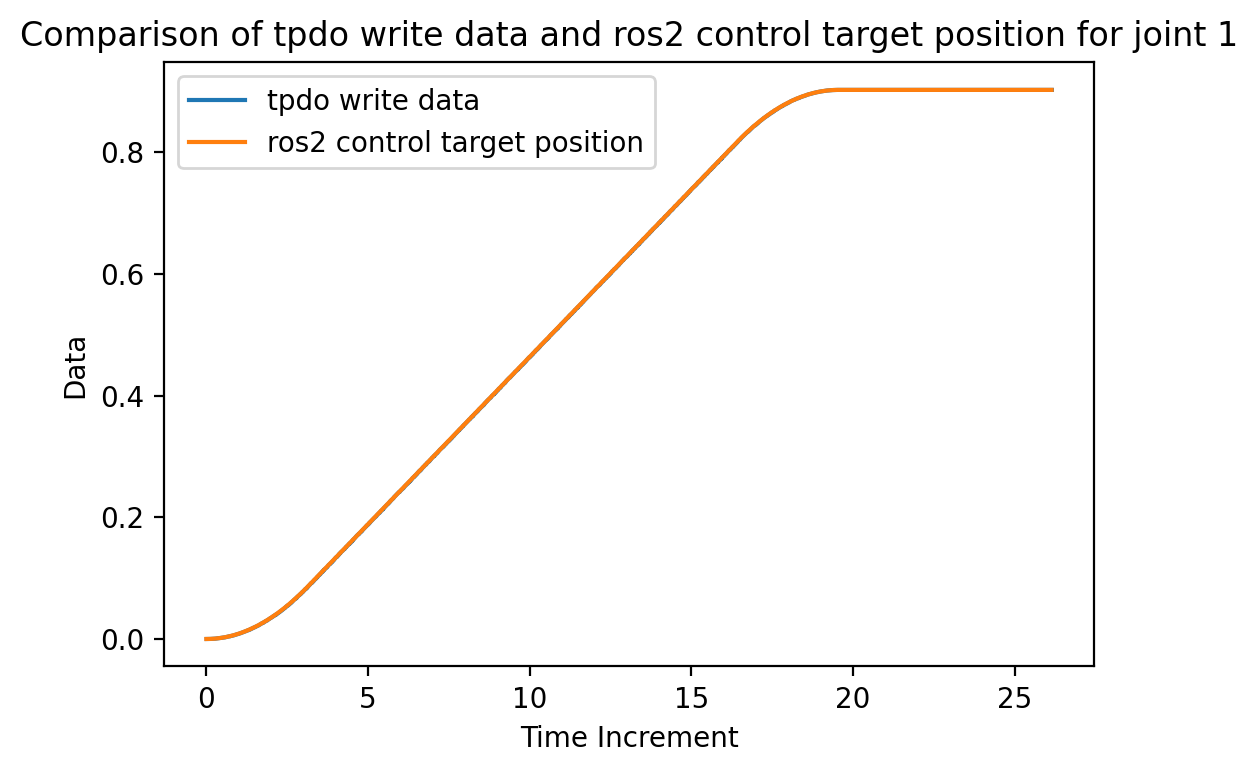

In [17]:
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots()

# plot the data column in tpdo_prbt_joint_2
tpdo_prbt_joint_1 = tpdo_prbt_joint_1.sample(n=1000)
tpdo_prbt_joint_1 = tpdo_prbt_joint_1.sort_values(by=['time_increment'], ascending=True)
tpdo_joint_1_data = np.array(tpdo_prbt_joint_1['data'])
tpdo_joint_1_ti = np.array(tpdo_prbt_joint_1['time_increment'])
ax.plot(tpdo_joint_1_ti, tpdo_joint_1_data, label='tpdo write data')

# plot the data column in rc_prbt_joint_1
rc_joint_1_data = np.array(rc_prbt_joint_1['data'])
rc_joint_1_ti = np.array(rc_prbt_joint_1['time_increment'])
ax.plot(rc_joint_1_ti, rc_joint_1_data, label='ros2 control target position')

# set the axis labels and title
ax.set_xlabel('Time Increment')
ax.set_ylabel('Data')
ax.set_title('Comparison of tpdo write data and ros2 control target position for joint 1')


# add a legend to the plot
ax.legend()
plt.gcf().set_dpi(200)
# show the plot
plt.show()

In [34]:
time_diff = np.array(tpdo_prbt_joint_2['time_increment']).astype(np.float64)

# calculate the expected time increment
time_increment = np.mean(tpdo_prbt_joint_1['time_increment'])

print(f'mean time increment: {time_increment}')

# check if any time differences are greater than the expected time increment
if any(time_diff > 14):
    print('Data skip detected!')
else:
    print('No data skip detected.')

num_skips = np.sum(time_diff > 14)

print(f'Total number of time skips: {num_skips}')
print(f'Max time difference: {np.max(time_diff)}')

mean time increment: 12.900278658307
Data skip detected!
Total number of time skips: 1214
Total number of data points: 2614
Max time difference: 26.160989487
Min time difference: 0.008056604


In [ ]:
# create a figure and axis object
fig, ax = plt.subplots()

# plot the data column in tpdo_prbt_joint_2
tpdo_prbt_joint_2 = tpdo_prbt_joint_2.sample(n=500)
tpdo_prbt_joint_2 = tpdo_prbt_joint_2.sort_values(by=['time_increment'], ascending=True)
tpdo_joint_2_data = np.array(tpdo_prbt_joint_2['data'])
tpdo_joint_2_ti = np.array(tpdo_prbt_joint_2['time_increment'])
ax.plot(tpdo_joint_2_ti, tpdo_joint_2_data, label='tpdo write data')

# plot the data column in rc_prbt_joint_2
rc_joint_2_data = np.array(rc_prbt_joint_2['data'])
rc_joint_2_ti = np.array(rc_prbt_joint_2['time_increment'])
ax.plot(rc_joint_2_ti, rc_joint_2_data, label='ros2 control target position')

# set the axis labels and title
ax.set_xlabel('Time Increment')
ax.set_ylabel('Data in rad')
ax.set_title('Comparison of tpdo write data and ros2 control target position for joint 2')


# add a legend to the plot
ax.legend()
plt.gcf().set_dpi(200)
# show the plot
plt.show()

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots()

# plot the data column in tpdo_prbt_joint_2
tpdo_prbt_joint_3 = tpdo_prbt_joint_3.sample(n=500)
tpdo_prbt_joint_3 = tpdo_prbt_joint_3.sort_values(by=['time_increment'], ascending=True)
tpdo_joint_3_data = np.array(tpdo_prbt_joint_3['data'])
tpdo_joint_3_ti = np.array(tpdo_prbt_joint_3['time_increment'])
ax.plot(tpdo_joint_3_ti, tpdo_joint_3_data, label='tpdo write data')

# plot the data column in rc_prbt_joint_2
rc_joint_3_data = np.array(rc_prbt_joint_3['data'])
rc_joint_3_ti = np.array(rc_prbt_joint_3['time_increment'])
ax.plot(rc_joint_3_ti, rc_joint_3_data, label='ros2 control target position')

# set the axis labels and title
ax.set_xlabel('Time Increment')
ax.set_ylabel('Data in rad')
ax.set_title('Comparison of tpdo write data and ros2 control target position for joint 3')


# add a legend to the plot
ax.legend()
plt.gcf().set_dpi(200)
# show the plot
plt.show()

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots()

# plot the data column in tpdo_prbt_joint_2
tpdo_prbt_joint_4 = tpdo_prbt_joint_4.sample(n=500)
tpdo_prbt_joint_4 = tpdo_prbt_joint_4.sort_values(by=['time_increment'], ascending=True)
tpdo_joint_4_data = np.array(tpdo_prbt_joint_4['data'])
tpdo_joint_4_ti = np.array(tpdo_prbt_joint_4['time_increment'])
ax.plot(tpdo_joint_4_ti, tpdo_joint_4_data, label='tpdo write data')

# plot the data column in rc_prbt_joint_2
rc_joint_4_data = np.array(rc_prbt_joint_4['data'])
rc_joint_4_ti = np.array(rc_prbt_joint_4['time_increment'])
ax.plot(rc_joint_4_ti, rc_joint_4_data, label='ros2 control target position')

# set the axis labels and title
ax.set_xlabel('Time Increment')
ax.set_ylabel('Data in rad')
ax.set_title('Comparison of tpdo write data and ros2 control target position for joint 4')


# add a legend to the plot
ax.legend()
plt.gcf().set_dpi(200)
# show the plot
plt.show()

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots()

# plot the data column in tpdo_prbt_joint_2
tpdo_prbt_joint_5 = tpdo_prbt_joint_5.sample(n=500)
tpdo_prbt_joint_5 = tpdo_prbt_joint_5.sort_values(by=['time_increment'], ascending=True)
tpdo_joint_5_data = np.array(tpdo_prbt_joint_5['data'])
tpdo_joint_5_ti = np.array(tpdo_prbt_joint_5['time_increment'])
ax.plot(tpdo_joint_5_ti, tpdo_joint_5_data, label='tpdo write data')

# plot the data column in rc_prbt_joint_2
rc_joint_5_data = np.array(rc_prbt_joint_5['data'])
rc_joint_5_ti = np.array(rc_prbt_joint_5['time_increment'])
ax.plot(rc_joint_5_ti, rc_joint_5_data, label='ros2 control target position')

# set the axis labels and title
ax.set_xlabel('Time Increment')
ax.set_ylabel('Data in rad')
ax.set_title('Comparison of tpdo write data and ros2 control target position for joint 5')


# add a legend to the plot
ax.legend()
plt.gcf().set_dpi(200)
# show the plot
plt.show()

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots()

# plot the data column in tpdo_prbt_joint_2
tpdo_prbt_joint_6 = tpdo_prbt_joint_6.sample(n=500)
tpdo_prbt_joint_6 = tpdo_prbt_joint_6.sort_values(by=['time_increment'], ascending=True)
tpdo_joint_6_data = np.array(tpdo_prbt_joint_6['data'])
tpdo_joint_6_ti = np.array(tpdo_prbt_joint_6['time_increment'])
ax.plot(tpdo_joint_6_ti, tpdo_joint_6_data, label='tpdo write data')

# plot the data column in rc_prbt_joint_2
rc_joint_6_data = np.array(rc_prbt_joint_6['data'])
rc_joint_6_ti = np.array(rc_prbt_joint_6['time_increment'])
ax.plot(rc_joint_6_ti, rc_joint_6_data, label='ros2 control target position')

# set the axis labels and title
ax.set_xlabel('Time Increment')
ax.set_ylabel('Data in rad')
ax.set_title('Comparison of tpdo write data and ros2 control target position for joint 6')


# add a legend to the plot
ax.legend()
plt.gcf().set_dpi(200)
# show the plot
plt.show()